Declaração de bibliotecas e funções de apoio

In [29]:
import itertools
import numpy as np
import pandas as pd
from math import ceil
import matplotlib.pyplot as plt
from numpy.typing import NDArray
from abc import ABC, abstractmethod
from IPython.display import display
from sklearn.metrics import r2_score

Calcular métricas de regressão

In [30]:
def evaluate_regression_metrics(y_test: NDArray, y_predict: NDArray):
    y_test = y_test.flatten()
    y_predict = y_predict.flatten()

    mse = np.mean((y_test - y_predict) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_test - y_predict))
    r2 = r2_score(y_test, y_predict)

    metrics = {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2_score': r2,
    }
    return metrics

Declaração dos escaladores MinMax e ZScore

In [31]:
class Scaler(ABC):
    @abstractmethod
    def normalize(self, X: NDArray, update_params: bool = False) -> NDArray:
        pass

    @abstractmethod
    def denormalize(self, X: NDArray) -> NDArray:
        pass

class ZScore(Scaler):
    def __init__(self):
        self.mean: NDArray = None
        self.std: NDArray = None
        pass

    def normalize(self, X: NDArray, update_params: bool = False):
        mean = np.mean(X, axis=0) if self.mean is None or update_params else self.mean
        std = np.std(X, axis=0) if self.std is None or update_params else self.std

        self.mean = mean
        self.std = std

        return (X - mean) / (std + 1e-8)

    def denormalize(self, X: NDArray):
        return X * self.std + self.mean

class MinMax(Scaler):
    def __init__(self):
        self.min = None
        self.max = None
        pass

    def normalize(self, X: NDArray, update_params: bool = False):
        min_val = np.min(X, axis=0) if self.min is None or update_params else self.min
        max_val = np.max(X, axis=0) if self.max is None or update_params else self.max

        self.min = min_val
        self.max = max_val

        return (X - min_val) / (max_val - min_val + 1e-8)

    def denormalize(self, X: NDArray):
        return X * (self.max - self.min) + self.min


Implementação do MLP para Regressão

In [32]:
class Model(ABC):
    has_training_costs = False

    @abstractmethod
    def fit(self, X: NDArray, y: NDArray, **kwargs):
        pass

    @abstractmethod
    def predict(self, X: NDArray) -> NDArray:
        pass

class MLP(Model):
    has_training_costs = True

    def __init__(self, hidden_layer_sizes: tuple[int, ...], learning_rate: float, epochs: int, momentum: float, batch_size: int = 32):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.momentum = momentum
        self.in_scaler = ZScore()
        self.out_scaler = MinMax()
        self.weights, self.biases = [], []
        self.velocities_w, self.velocities_b = [], []
        self.costs, self.test_costs = [], []

    def _relu(self, Z):
        return np.maximum(0, Z)

    def _relu_derivative(self, Z):
        return Z > 0

    def _forward(self, X: NDArray):
        for i, (W, b) in enumerate(zip(self.weights, self.biases)):
            Z = X @ W + b
            X = self._relu(Z) if i < len(self.weights) - 1 else Z

        return X

    def _preprocess_input(self, X: NDArray, update_params=False):
        X = self.in_scaler.normalize(X, update_params)
        return X

    def _preprocess_output(self, y: NDArray, update_params=False):
        y = self.out_scaler.normalize(y, update_params)
        return y.reshape(-1, 1)

    def fit(self, X: NDArray, y: NDArray, X_test: NDArray, y_test: NDArray):
        X = self._preprocess_input(X, update_params=True)
        y = self._preprocess_output(y, update_params=True)
        X_test = self._preprocess_input(X_test)
        y_test = self._preprocess_output(y_test)

        n, m = X.shape
        layer_sizes = [m, *self.hidden_layer_sizes, 1]

        self.weights = [np.random.randn(ins, outs) * np.sqrt(2./ins) for ins, outs in zip(layer_sizes[:-1], layer_sizes[1:])]
        self.biases = [np.zeros((1, size)) for size in layer_sizes[1:]]
        self.velocities_w = [np.zeros_like(w) for w in self.weights]
        self.velocities_b = [np.zeros_like(b) for b in self.biases]
        self.costs, self.test_costs = [], []

        for epoch in range(self.epochs):
            shuffled_indices = np.random.permutation(n)
            X_shuffled, y_shuffled = X[shuffled_indices], y[shuffled_indices]
            epoch_costs = []

            for i in range(0, n, self.batch_size):
                X_b, y_b = X_shuffled[i:i+self.batch_size], y_shuffled[i:i+self.batch_size]
                b_n = len(X_b)
                activations = [X_b]; Zs = []; A = X_b
                for j, (W, b) in enumerate(zip(self.weights, self.biases)):
                    Z = A @ W + b; Zs.append(Z)
                    A = self._relu(Z) if j < len(self.weights) - 1 else Z
                    activations.append(A)

                epoch_costs.append(np.mean((A - y_b)**2))

                dZ = A - y_b
                for j in range(len(self.weights) - 1, -1, -1):
                    dW = (activations[j].T @ dZ) / b_n; db = np.sum(dZ, axis=0, keepdims=True) / b_n
                    if j > 0: dZ = (dZ @ self.weights[j].T) * self._relu_derivative(Zs[j-1])
                    self.velocities_w[j] = self.momentum * self.velocities_w[j] - self.learning_rate * dW
                    self.velocities_b[j] = self.momentum * self.velocities_b[j] - self.learning_rate * db
                    self.weights[j] += self.velocities_w[j]; self.biases[j] += self.velocities_b[j]

            self.costs.append(np.mean(epoch_costs))
            A_test = self._forward(X_test)
            test_cost = np.mean((A_test - y_test)**2)
            self.test_costs.append(test_cost)

    def predict(self, X: NDArray):
        X = self._preprocess_input(X)
        y_pred = self._forward(X)

        return self.out_scaler.denormalize(y_pred)


Classes para treinar vários modelos usando validação cruzada (K-Folds) e Grid Search

In [33]:
class KFoldTrainer:
    '''
    Treina um modelo (instanciado com hyper parâmetros), separando k partições de treino/validação
    Salva a média das métricas de cada validação feita
    '''
    def __init__(self, k: int, dataset: NDArray, model: Model):
        self.k = k
        self.dataset = dataset
        self.model = model
        self.metrics = None

    def fit(self):
        metrics = {
            'mse': np.zeros(self.k),
            'rmse': np.zeros(self.k),
            'mae': np.zeros(self.k),
            'r2_score': np.zeros(self.k),
        }
        for i, dataset_fold in enumerate(self._genereate_dataset_k_folds()):
            X_train, y_train, X_validation, y_validation = dataset_fold

            params = [X_train, y_train]
            if self.model.has_training_costs:
                params.extend([X_validation, y_validation])

            self.model.fit(*params)

            y_predict = self.model.predict(X_validation)
            metrics_i = evaluate_regression_metrics(y_validation, y_predict)
            for key, value in metrics_i.items():
                metrics[key][i] = value

        self.metrics = {key: np.mean(value) for key, value in metrics.items()}

    def _genereate_dataset_k_folds(self):
        shuffled_dataset = self.dataset.copy()
        np.random.shuffle(shuffled_dataset)
        X, y = shuffled_dataset[:, :-1], shuffled_dataset[:, -1].reshape((-1, 1))
        validation_size_percent = 1 / self.k
        n, _ = X.shape
        validation_size = ceil(n * validation_size_percent)

        for i in range(self.k):
            start, end = i * validation_size, (i + 1) * validation_size if i < self.k - 1 else n
            X_validation, y_validation = X[start:end], y[start:end]
            X_train = np.concatenate([X[:start], X[end:]])
            y_train = np.concatenate([y[:start], y[end:]])
            yield X_train, y_train, X_validation, y_validation

class GridSearchTrainer:
    '''
    Instancia um modelo com cada combinação de hiperparâmetros e usa KFoldTrainer para validação cruzada.
    Salva o melhor modelo com base no menor Erro Quadrático Médio (MSE).
    '''
    def __init__(self, k: int, dataset: NDArray, model_class: type[Model], hyper_params: dict[str, list]):
        self.k = k
        self.dataset = dataset
        self.model_class = model_class
        self.hyper_params = hyper_params
        self.best_model, self.best_hyper_params, self.best_metrics = None, None, None

    def fit(self):
        params_names = list(self.hyper_params.keys())
        grid = list(itertools.product(*self.hyper_params.values()))
        best_model, best_hyper_params, best_metrics = None, None, None

        for params_values in grid:
            params = dict(zip(params_names, params_values))
            model = self.model_class(**params)
            k_fold_trainer = KFoldTrainer(self.k, self.dataset, model)
            k_fold_trainer.fit()
            mse = k_fold_trainer.metrics['mse']

            if best_model is None or mse < best_metrics['mse']:
                best_metrics = k_fold_trainer.metrics
                best_model = model
                best_hyper_params = dict(zip(params_names, params_values))

        self.best_model = best_model
        self.best_hyper_params = best_hyper_params
        self.best_metrics = best_metrics

class KFoldMultiModelsTrainer(KFoldTrainer):
    def __init__(self, k: int, dataset: NDArray, models: dict[str, tuple[type[Model], dict[str, list]]]):
        self.k = k
        self.dataset = dataset
        self.models = models

    def fit(self):
        trained_models = dict()
        metric_keys = ['mse', 'rmse', 'mae', 'r2_score']
        for model_name, (model_class, hyper_params) in self.models.items():
            model_attributes = {
                'metrics_train': {metric: np.zeros(self.k) for metric in metric_keys},
                'metrics_test': {metric: np.zeros(self.k) for metric in metric_keys},
                'hyper_params': {param: np.zeros(self.k, dtype=object) for param in hyper_params.keys()},
                'model': np.zeros(self.k, dtype=object)
            }
            for i, (X_train, y_train, X_test, y_test) in enumerate(self._genereate_dataset_k_folds()):
                print(f"Treinando {model_name} no Fold {i+1}/{self.k}...")
                dataset_train = np.c_[X_train, y_train]
                trainer = GridSearchTrainer(self.k, dataset_train, model_class, hyper_params)
                trainer.fit()
                y_predict = trainer.best_model.predict(X_test)
                test_metrics = evaluate_regression_metrics(y_test, y_predict)

                for metric in metric_keys:
                    model_attributes['metrics_train'][metric][i] = trainer.best_metrics[metric]
                    model_attributes['metrics_test'][metric][i] = test_metrics[metric]
                for param in hyper_params.keys():
                    model_attributes['hyper_params'][param][i] = trainer.best_hyper_params[param]
                model_attributes['model'][i] = trainer.best_model

            trained_models[model_name] = model_attributes
        print("\nTreinamento concluído!")
        return trained_models

Funções auxiliares para plotagem

In [34]:
def plot_costs(train_costs: NDArray, test_costs: NDArray, title: str):
    plt.figure(figsize=(10, 6))
    plt.plot(train_costs, label='Custo de Treinamento (MSE)')
    plt.plot(test_costs, label='Custo de Validação (MSE)')
    plt.xlabel('Épocas')
    plt.ylabel('Erro Quadrático Médio')
    plt.title(f'Função Custo {title}')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_models_metrics(trained_models: dict[str, dict[str, dict[str, float]]]):
    test_metrics = {name: results['metrics_test'] for name, results in trained_models.items()}

    df = pd.DataFrame(test_metrics).T
    table = df.map(lambda x: f"{np.mean(x):.4f} ± {1.96 * np.std(x) / np.sqrt(len(x)):.4f}")
    table.columns = ['MSE', 'RMSE', 'MAE', 'R2 Score']

    def highlight_best(s):
        is_max = s == s.max()
        is_min = s == s.min()
        styles = []
        for idx, v in enumerate(s.index):
            if v == 'R2 Score':
                if is_max[idx]: styles.append('font-weight:bold; color:red')
                else: styles.append('')
            else:
                if is_min[idx]: styles.append('font-weight:bold; color:red')
                else: styles.append('')
        return styles

    df.map(lambda x: np.mean(x))
    styled_table = table.style.apply(highlight_best, axis=0)
    display(styled_table)


# Questão 01 -> items a,b

1. Lendo o dataset 'concrete.csv'
2. Escolhendo o MLP para fazer os treinamentos e validações.
3. Definindo os possíveis valores dos hiperparâmetros para o grid search.
4. Treinando os modelos usando 5 partições para testes cruzados e 5 partições internas para validação cruzada (no GridSearch).
5. Plotando a tabela com a média e o intervalo de confiança das médias dos errors de cada modelo, e o gráfico dos custos do MLP.

Treinando MLP no Fold 1/5...
Treinando MLP no Fold 2/5...
Treinando MLP no Fold 3/5...
Treinando MLP no Fold 4/5...
Treinando MLP no Fold 5/5...

Treinamento concluído!


/tmp/ipykernel_98196/3444391249.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if is_min[idx]: styles.append('font-weight:bold; color:red')


,MSE,RMSE,MAE,R2 Score
MLP,53.3406 ± 5.3136,7.2920 ± 0.3587,5.2655 ± 0.3888,0.8053 ± 0.0331


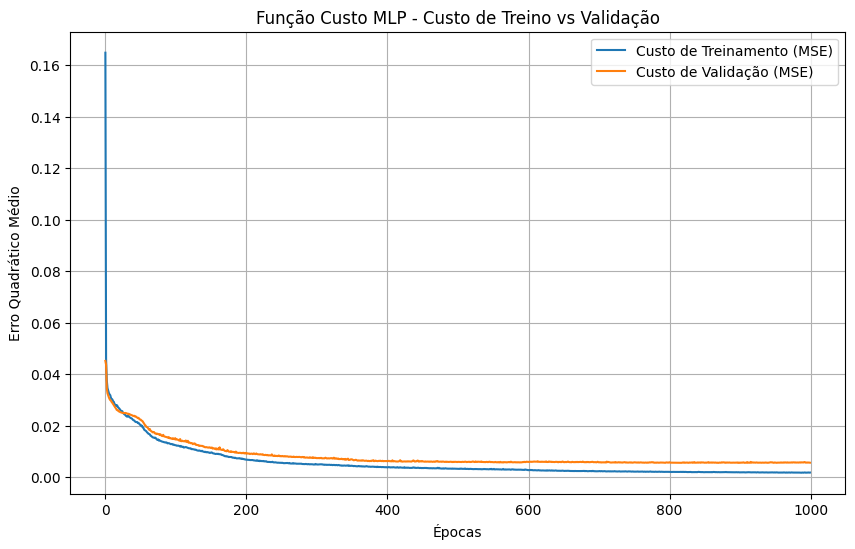

In [35]:
dataset = np.genfromtxt('concrete.csv', delimiter=',')

k = 5
np.random.seed(42)

models = {
    'MLP': (MLP, { 'momentum': [0.9, 0.99], 'hidden_layer_sizes': [(64, 16, 4)], 'learning_rate': [0.01, 0.001], 'epochs': [100, 1000] }),
}

trainer = KFoldMultiModelsTrainer(k, dataset, models)
trained_models = trainer.fit()

plot_models_metrics(trained_models)

np.random.seed(42)
dataset_copy = dataset.copy()
np.random.shuffle(dataset_copy)
X, y = dataset_copy[:, :-1], dataset_copy[:, -1].reshape((-1, 1))
n = X.shape[0]
test_size = ceil(n * (1 / k))
X_test_first_fold = X[:test_size]
y_test_first_fold = y[:test_size]

for model_name, attributes in trained_models.items():
    best_model_first_fold = attributes['model'][0]

    if best_model_first_fold.has_training_costs:
        plot_costs(best_model_first_fold.costs, best_model_first_fold.test_costs, f"{model_name} - Custo de Treino vs Validação")
